# Transformer로 번역기 만들기

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
! sudo apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("한글")

한글


In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 7.3 MB/s 


In [5]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import sentencepiece as spm

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook
import random


print(tf.__version__)

2.8.0


In [6]:
kor_path = os.path.join('./drive/MyDrive/transformer', 'korean-english-park.train.ko')
eng_path = os.path.join('./drive/MyDrive/transformer', 'korean-english-park.train.en')

In [7]:
with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()
print("Data Size:({},{})".format(len(kor), len(eng)))
print("Example:")

cnt = 0
for ko, en in zip(kor, eng):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

In [8]:
def clean_corpus(kor, eng):
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

In [9]:
cleaned_corpus = clean_corpus(kor, eng)
len(cleaned_corpus)

78968

In [10]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() #- 소문자 변환
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence) #- 알파벳, 문장부호, 한글 이외는 제거
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = sentence.strip() #- 양쪽 공백 제거
    return sentence

In [11]:
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [12]:
cleaned_corpus[1]

('원문 & 독해설명 인쇄',
 'The company filed for court supervision at the Suwon District Court yesterday.')

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [14]:
ko_test_txts = ['세계기상기구는 “코로나19에 따른 경제 활동 둔화로 탄소 배출이 일시적으로 줄었지만, 대기 중 이산화탄소 농도에 뚜렷한 영향을 주지 못했다”고 설명했다.','기후변화 대응·적응에 필요한 재원 분담 과정에서 나타나는 선진국과 개발도상국의 이견도 오래 묵은 논쟁거리다.']
en_test_txts = ['Democrats, including President Biden, are lobbying for Senator Joe Manchin’s support, knowing he is a crucial swing vote on their domestic agenda.','The contest to fill a vacant State House seat in South Texas has exposed the vulnerabilities of a Democratic stronghold.']

In [15]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [16]:
testSP(ko_tokenizer, ko_test_txts)

[['▁세계',
  '기',
  '상',
  '기구',
  '는',
  '▁',
  '“',
  '코',
  '로',
  '나',
  '19',
  '에',
  '▁따른',
  '▁경제',
  '▁활동',
  '▁둔화',
  '로',
  '▁탄소',
  '▁배출',
  '이',
  '▁일시적',
  '으로',
  '▁줄',
  '었지만',
  ',',
  '▁대기',
  '▁중',
  '▁이산화탄소',
  '▁농도',
  '에',
  '▁뚜렷',
  '한',
  '▁영향',
  '을',
  '▁주지',
  '▁못했다',
  '”',
  '고',
  '▁설명했다',
  '.'],
 ['▁기후변화',
  '▁대응',
  '·',
  '적',
  '응',
  '에',
  '▁필요한',
  '▁재원',
  '▁분담',
  '▁과정에서',
  '▁나타나',
  '는',
  '▁선진국',
  '과',
  '▁개발도상국',
  '의',
  '▁이견',
  '도',
  '▁오래',
  '▁묵',
  '은',
  '▁논쟁거리',
  '다',
  '.']]

In [17]:
testSP(en_tokenizer, en_test_txts)

[['<s>',
  '▁',
  'D',
  'em',
  'ocrats',
  ',',
  '▁including',
  '▁',
  'P',
  'res',
  'ident',
  '▁',
  'B',
  'iden',
  ',',
  '▁are',
  '▁lobby',
  'ing',
  '▁for',
  '▁',
  'S',
  'en',
  'ator',
  '▁',
  'J',
  'o',
  'e',
  '▁',
  'M',
  'an',
  'chi',
  'n',
  '’',
  's',
  '▁support',
  ',',
  '▁knowing',
  '▁he',
  '▁is',
  '▁a',
  '▁crucial',
  '▁swing',
  '▁vote',
  '▁on',
  '▁their',
  '▁domestic',
  '▁agenda',
  '.',
  '</s>'],
 ['<s>',
  '▁',
  'T',
  'he',
  '▁contest',
  '▁to',
  '▁fill',
  '▁a',
  '▁vacant',
  '▁',
  'S',
  'tate',
  '▁',
  'H',
  'ouse',
  '▁seat',
  '▁in',
  '▁',
  'S',
  'out',
  'h',
  '▁',
  'T',
  'ex',
  'as',
  '▁has',
  '▁exposed',
  '▁the',
  '▁vulnerabilities',
  '▁of',
  '▁a',
  '▁',
  'D',
  'e',
  'mo',
  'cratic',
  '▁stronghold',
  '.',
  '</s>']]

In [18]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

#- 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

#- 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [19]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions 
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [21]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        #- Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        #- Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        #- Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        #- 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        #- 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        #- 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        #- 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        #- 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #- 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        #- Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        #- Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        #- Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        #- Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [27]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [28]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [29]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [30]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [31]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [32]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [33]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [34]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [35]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s first lady obama s president elect barack obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the coastal coast.
Input: 커피는 필요 없다.
Predicted translation: the company is not to be.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the plane was killed in the dead.
Input: 투표는 시민의 권리이다
Predicted translation: the government has been allowed to the country s political party.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company is expected to the million of the country, and the report, and the report.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the united states is expected to be the united states, the united states, which is expected to be the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: the year old government has been sentenced to the international crisis in , and the international crisis.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big lead in the obama campaign.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the most popular cities.
Input: 커피는 필요 없다.
Predicted translation: coffee coffee, coffee, coffee, coffee, coffee, said.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were dead in the southern city of the dead.
Input: 투표는 시민의 권리이다
Predicted translation: the political rights groups are rights to be the right to the rights of the rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company has been a bit of the size of the united states, which is the first time.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the big policy is the latest in the united states, and the energy department has said.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park geun hye, who is the first time in the international community, has been a very good thing.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama has a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city.
Input: 커피는 필요 없다.
Predicted translation: no longer.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed.
Input: 투표는 시민의 권리이다
Predicted translation: the vote has the right to vote.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company has been ordered to end the day, but the government has said it was not known as the risk of contracting.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy based institute of energy is the largest ever in the united states, which is the largest ever in the united states.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: pak, a few years ago, said the organization s funeral was not a years ago.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president barack obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city.
Input: 커피는 필요 없다.
Predicted translation: no one does not need a small thing.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least seven people were killed.
Input: 투표는 시민의 권리이다
Predicted translation: rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company s spokesman for the company s office said that the outbreak of the outbreak of the outbreak of the outbreak.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy efficient and the number of new cases of swine flu, which is likely to be used to make surely produce a similar shift in the region, where the nation s energy is likely to make it.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park jae chun said that a few years ago, as a former international community secretary of state.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: they went into the mountain.
Input: 커피는 필요 없다.
Predicted translation: no timetable was necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven died saturday in the southeastern city of americus.
Input: 투표는 시민의 권리이다
Predicted translation: rights campaigners say the rights of the rights movement
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company s case of mass street protests, known as the world s worst mass mass mass exodus.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy efficient policies, and the united states, are looking for coal, the fact that the policies are also reduced to the bush administration s policies.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago in the global interest rate, according to the international organization.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama sing nominee.
Input: 시민들은 도시 속에 산다.
Predicted translation: the big city of irbil is in the big city.
Input: 커피는 필요 없다.
Predicted translation: it s like a small.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died in the seven days.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is a right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the company s blood flowr, which includes a known unconscious and over the spread of the virus.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy, the energy department, is about to win some green, and have ad to win over the u.s. government s development, the energy secretary, the energy secretary, and the energy department s energy department said.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park s life has been sentenced to years in prison, so that the international interest rate has been regarded as a p

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is on the obama administration.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the kind of stands in the stands.
Input: 커피는 필요 없다.
Predicted translation: he doesn t have a good timetable.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: five people died on tuesday.
Input: 투표는 시민의 권리이다
Predicted translation: right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking coffee is being treated for include various stages of liver cancer, politically active and liver cancer.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy should light switch with a record high energy efficient and noted that the government is even stronger than in a decade.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park can stand in the international zone, sometimes as part of an international effort to combat global force.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president obama is off.
Input: 시민들은 도시 속에 산다.
Predicted translation: only a third of the city.
Input: 커피는 필요 없다.
Predicted translation: no action was necessary.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven people.
Input: 투표는 시민의 권리이다
Predicted translation: rights are no right to have rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking sound individuals for the nation s armed cancer cases, known as blood pressure and over the spread of the virus.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green producers, energy information secretary of state this administration, and we re looking for a true conflict, he said.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park now has a big step in a few years ago, since the international raw engag in democrats in a small confrontation.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama will be president
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the kind of casualties.
Input: 커피는 필요 없다.
Predicted translation: no fewer or small.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded.
Input: 투표는 시민의 권리이다
Predicted translation: voting rights
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunken drinking sound of dubai, united states, music, labour and japanese service does caused mass activity.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green operating a policies high, such as green energy jobs, and the government used to make it to make a vital shift to the bush administration.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park served as a few years ago, as a small problem in the global realize the international development.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is on capitol hill.
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are big in the city.
Input: 커피는 필요 없다.
Predicted translation: no action should be a kurdish
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died in the hospital of the deaths of monday.
Input: 투표는 시민의 권리이다
Predicted translation: she is a right for citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol could include a kibaki professor, a pentagon or name of the controversial wall street journal.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green, green sea, green mountain, meet this needs more energy than in the first and we have run up for the top in some developing countries.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago with internationalizingr hillary clinton.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is s hoping
Input: 시민들은 도시 속에 산다.
Predicted translation: the large part of the city s mountain is a big mountain.
Input: 커피는 필요 없다.
Predicted translation: the thing coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died and were killed.
Input: 투표는 시민의 권리이다
Predicted translation: the voting is the right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the benefits of june, known as blood pressure between australia and parliament to grow apart, is what caused to be considered process.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green light, green energy should boost defending dollars and change affairs, perhaps the administration s is southern industry.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park winger has been diagnosed with international correspondental ago, chun reiterated calls for a small group meeting in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obamas are being held.
Input: 시민들은 도시 속에 산다.
Predicted translation: only three other large immediately occur in the judges.
Input: 커피는 필요 없다.
Predicted translation: the no longer exists.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died over seven years.
Input: 투표는 시민의 권리이다
Predicted translation: that s the right person
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunken failed coup which makes pounding failed to known cabinet employees, dust, ill or over the atlantic coast.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: even though these dogs eat chinese policies and use the vital part of energy to win the disease, he says.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: need to speak at peace with international assistance for a few years, fighting efforts to transform into international waters.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the man s large place in the city of downtown.
Input: 커피는 필요 없다.
Predicted translation: there are no good thing.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died over the seven years.
Input: 투표는 시민의 권리이다
Predicted translation: rights are
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the dealing of a drunkenness and australian open the prolonged appointment to a fatal blow, various caused by lightning strikes.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy shouldn t whistler data, but he expected the administration s move to make more money.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: constitution was a few years ago to protest a larger anti war protesters later bilateral development in july.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is on rapidly land.
Input: 시민들은 도시 속에 산다.
Predicted translation: only the downtown american town is against.
Input: 커피는 필요 없다.
Predicted translation: the thing he needs to do.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the ride of battling human activity.
Input: 투표는 시민의 권리이다
Predicted translation: rights is
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunkenness for fuel and later, a secretary of brokered is trueiest.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green toys, green energy, obama s additional energy policy, stood by the government, and saw a young coal behind the current long vietnam administration s exports to the nation.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park now has been held in international mass gravesive century ago, keeping up your initial work.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is off.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens will have the go there in.
Input: 커피는 필요 없다.
Predicted translation: no model can coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died and seven died.
Input: 투표는 시민의 권리이다
Predicted translation: rights management
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunken include regular whole gang related suicide attacks, music, stalled later this month.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy technology, like the green energy giant for the increase, energy and target is more than major resource and power.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: constitution was directed at a small number of international hotelal militants in early march.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect is obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens in the big city of kuala lumpur.
Input: 커피는 필요 없다.
Predicted translation: there are no good at stake.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died and the fatalities come.
Input: 투표는 시민의 권리이다
Predicted translation: the votes are being rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol factors can cause more marked between , ba navy vessels including consumption, which sets fall.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: even though the green energy secretary, these pro business prices should be looking to move to make up for more than a century.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park activists have criticized stand for engagal protests in almost countries.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is correct.
Input: 시민들은 도시 속에 산다.
Predicted translation: the large city of only half an year.
Input: 커피는 필요 없다.
Predicted translation: it doesn t have a smaller coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and the death toll sent thursday.
Input: 투표는 시민의 권리이다
Predicted translation: the votes are being rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: day, this chief include the very could be key to over , diamonds, blowing away from overia.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: these were up policies, and for the moment, looking for the green energy crops even this perfect base from the administration s energy even more workers.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park jae said in a few years ago that these none of the personnel are free.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is to be on the obama campaign.
Input: 시민들은 도시 속에 산다.
Predicted translation: the protest is over in the city.
Input: 커피는 필요 없다.
Predicted translation: no coffee leaves coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seventh straight attack.
Input: 투표는 시민의 권리이다
Predicted translation: it is a right person.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunkenness could be announced in june following a controversial george ba of interest listening to the talks.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i suspect these spectacular rise, personnel, such as thursday, and because it is important to cut production any below the top in case.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is a few years ago, as a case thatduring a normally vulnerable bomb in a war against global summer.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is .
Input: 시민들은 도시 속에 산다.
Predicted translation: the man is home to a downtown.
Input: 커피는 필요 없다.
Predicted translation: there are no good at his hospital.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seventh straight month loss of , .
Input: 투표는 시민의 권리이다
Predicted translation: the vote right is the right for civil rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drunkenness of a drinking play between , and february is at the negotiating table, following a separate national intelligence service nis claim.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green energy secretary, working space post customers there also understand the spending personnel make it up the more coal industry work, employment and coal.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was established in over years ago at so many interna

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is to be president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are their third machine in the red?
Input: 커피는 필요 없다.
Predicted translation: no coffee auction is to coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and nearly died.
Input: 투표는 시민의 권리이다
Predicted translation: the votes are
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking alcohol could be over , between theater and february.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: these energy information technology should have a rise in place to any increase energy bigger than the top in lee administration, america, using energy technology industry analyst david use.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park now has been told that rapidly now there are crisis in international decades.


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park now has been told that rapidly now there are crisis in international decades.
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47751 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_

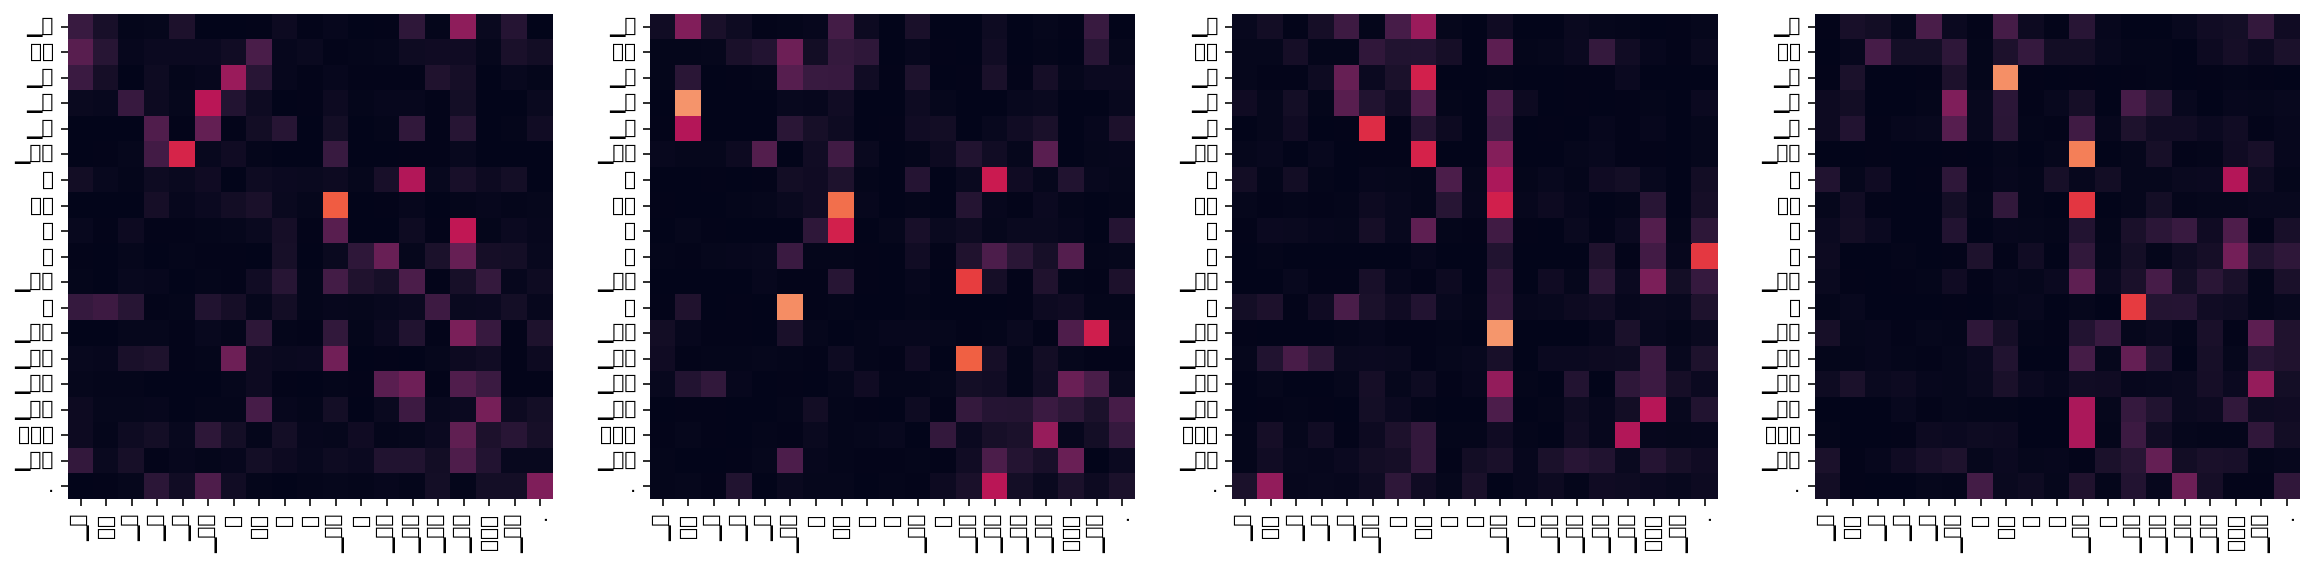

Encoder Layer 2


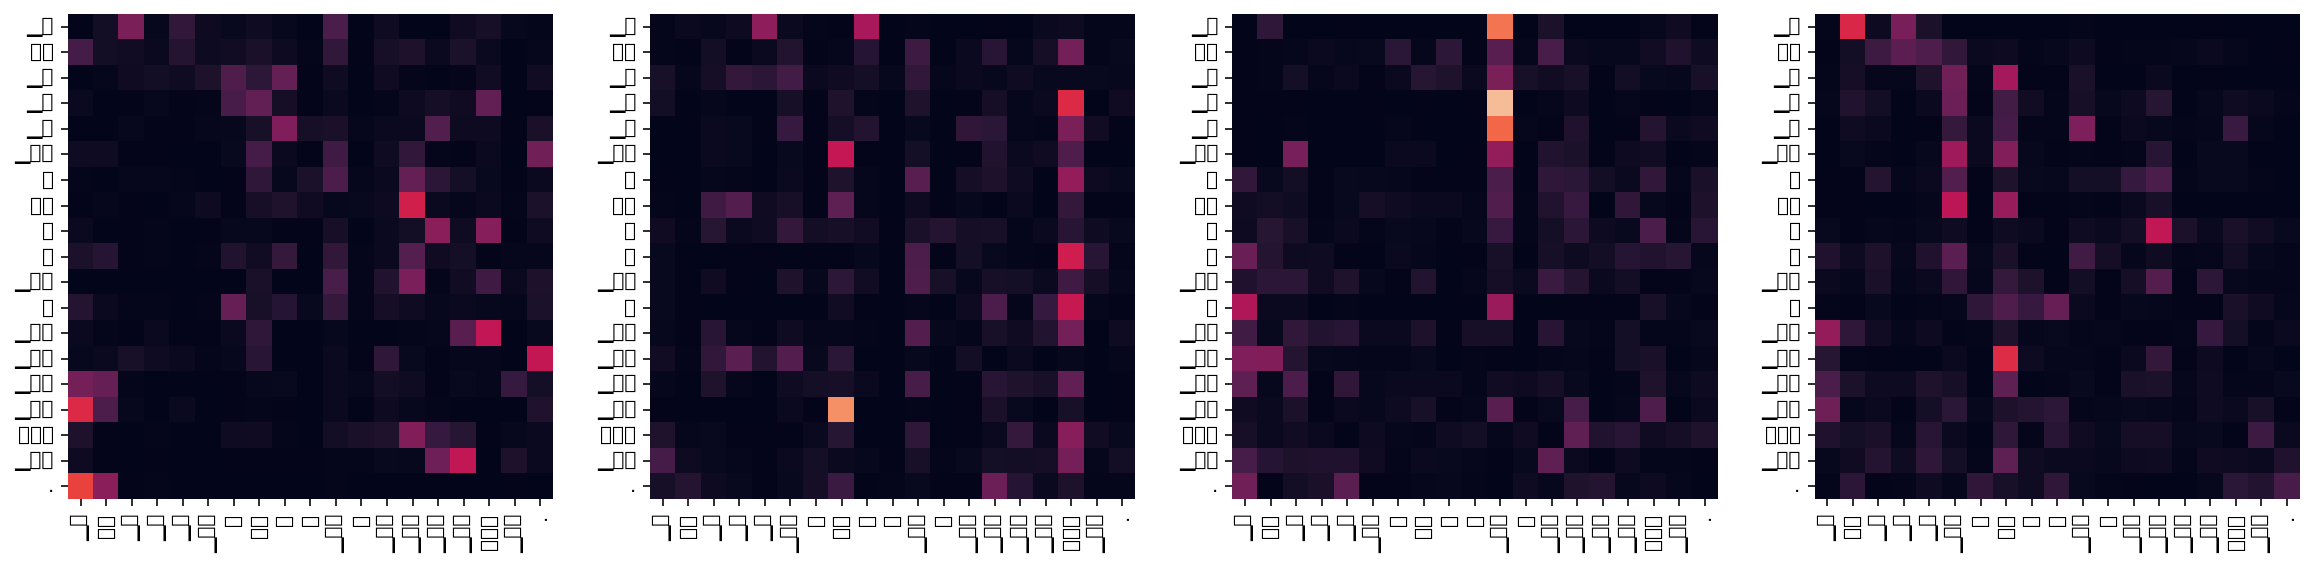

Decoder Self Layer 1


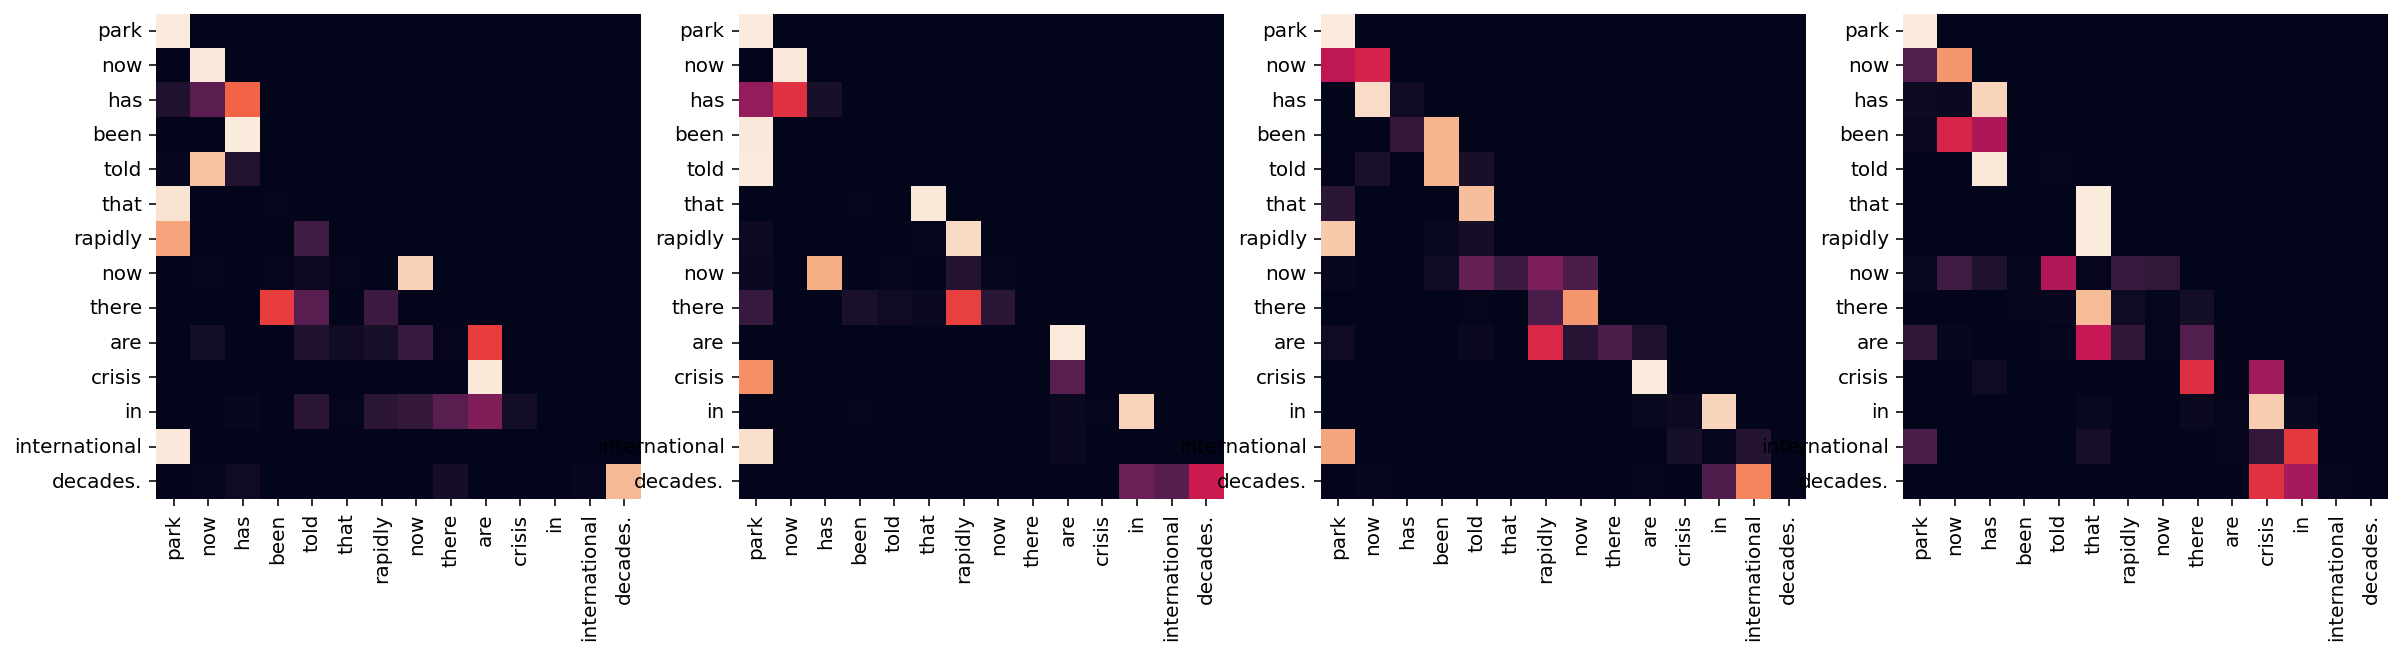

Decoder Src Layer 1


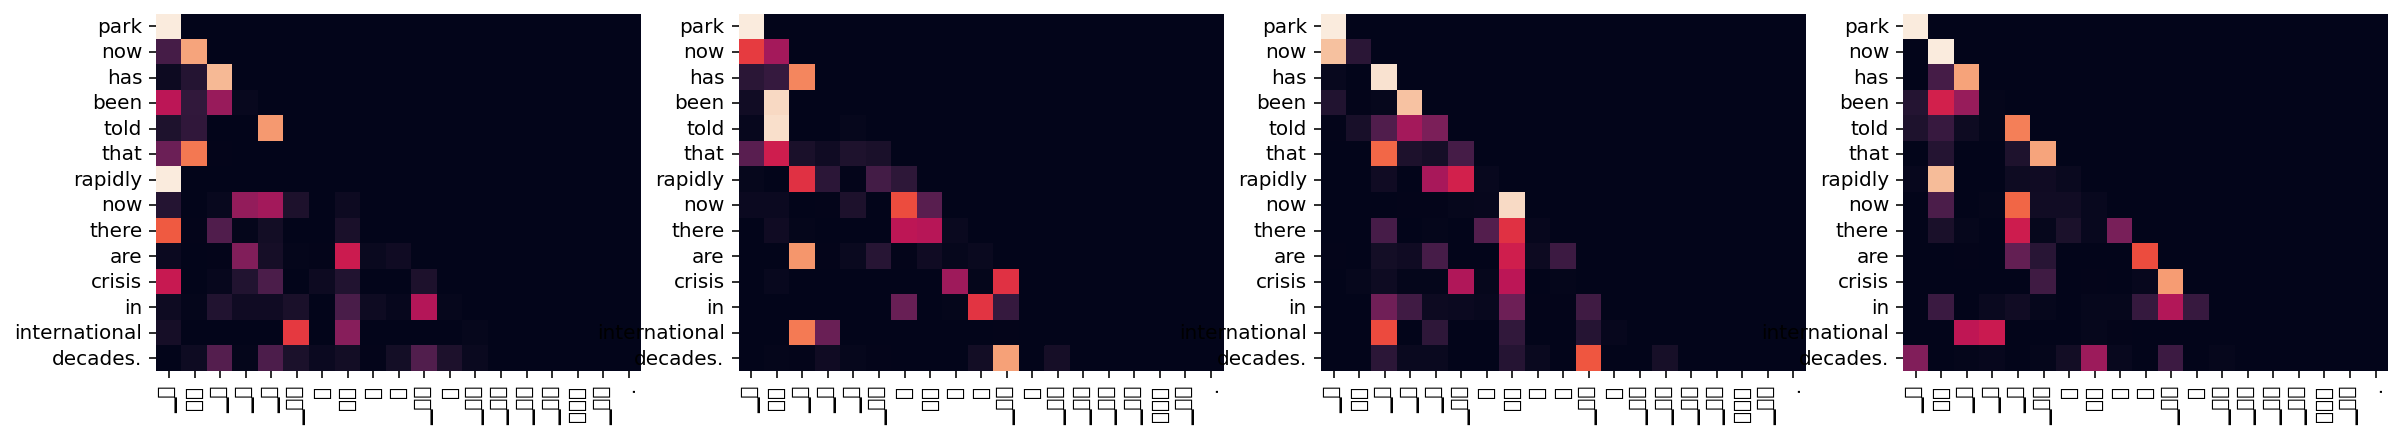

Decoder Self Layer 2


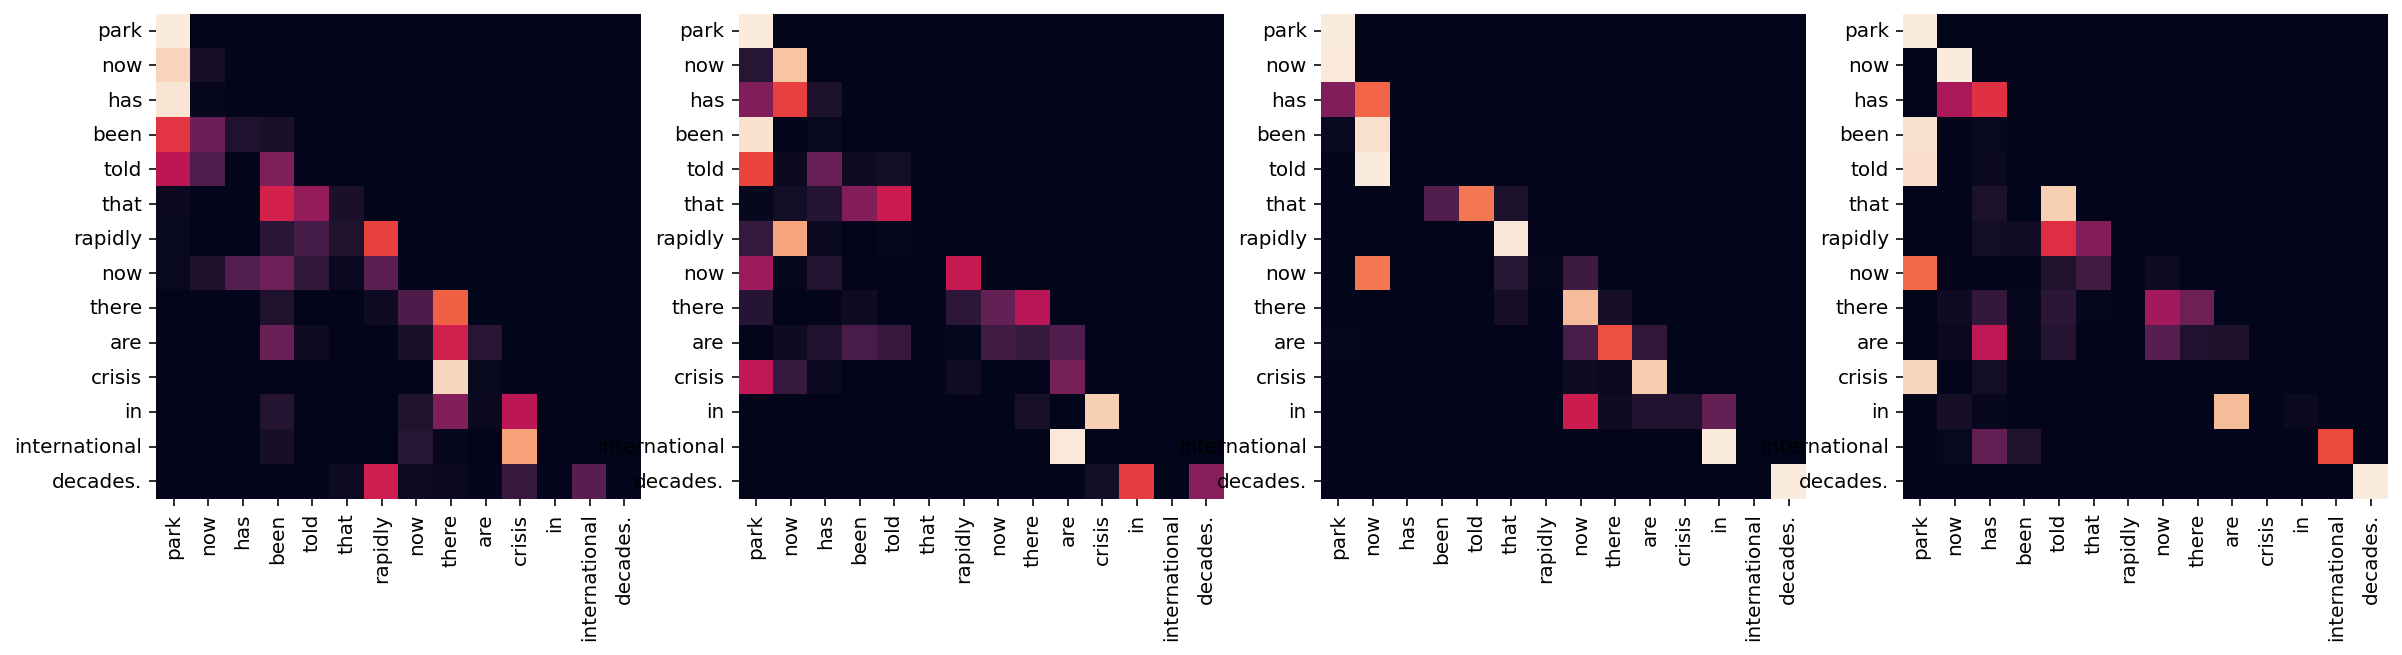

Decoder Src Layer 2


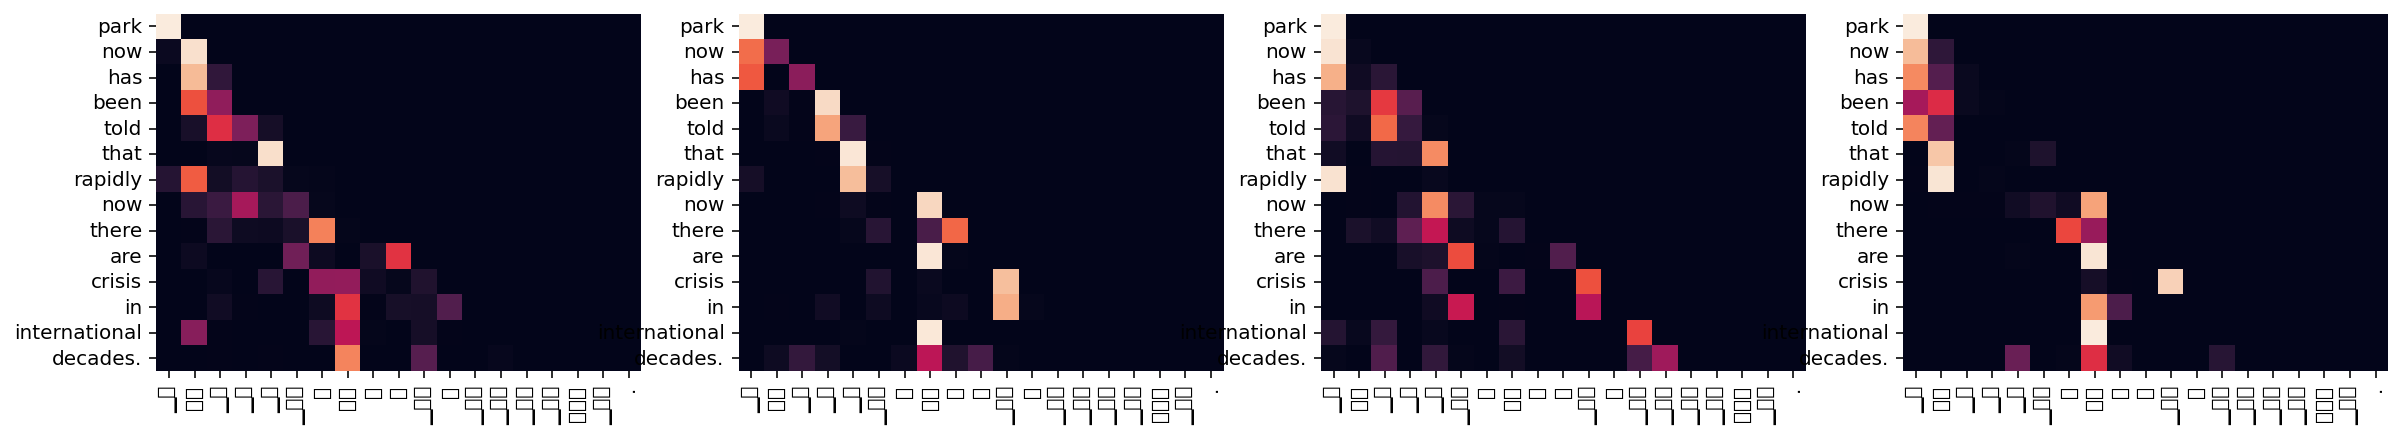

In [36]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "투표는 시민의 권리이다",
            "음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.",
            "친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.",
            "박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    if epoch == EPOCHS -1 : translate(example, transformer, ko_tokenizer, en_tokenizer, True)